https://github.com/artix41/RIM-pytorch/blob/master/rim-toy.ipynb

https://github.com/wmorning/DeepClean

In [1]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [3]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [4]:
sys.path.append('../code/utils/')
sys.path.append('../code/flowpm/')
import tools
from background import *
import tfpm 
import tfpmfuncs as tfpf
from tfpmconfig import Config


# PM

In [5]:
def pm(config, verbose=False):
    g = tf.Graph()
    with g.as_default():
        linear = tfpm.linfield(config, name='linear')
        icstate = tfpm.lptinit(linear, config, name='icstate')
        fnstate = tfpm.nbody(icstate, config, verbose=verbose, name='fnstate')
        final = tf.zeros_like(linear)
        final = tfpf.cic_paint(final, fnstate[0], boxsize=bs, name='final')
        tf.add_to_collection('pm', [linear, icstate, fnstate, final])
    return g


                                                                                                                                                                                                                                                                                                                                                   

#config = Config(bs=100, nc=32, seed=200, pkfile=pkfile)                                                                                                                                                                                                                                                                                                                   

def pmwhite(config, verbose=False):
    g = tf.Graph()
    with g.as_default():
        xx = tf.placeholder(tf.float32, (nc, nc, nc), name='white')
        whitec = tfpf.r2c3d(xx, norm=nc**3)
        lineark = tf.multiply(whitec, (pkmesh/bs**3)**0.5)
        linear = tfpf.c2r3d(lineark, norm=nc**3, name='linear')
        icstate = tfpm.lptinit(linear, config, name='icstate')
        fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
        final = tf.zeros_like(linear)
        final = tfpf.cic_paint(final, fnstate[0], boxsize=config['boxsize'], name='final')
        tf.add_to_collection('pm', [linear, icstate, fnstate, final])
    return g




In [6]:
#Generate DATA

pkfile = '../code/flowpm/Planck15_a1p00.txt'
stages = numpy.linspace(0.1, 1.0, 2, endpoint=True)
config = Config(bs=100, nc=32, seed=0, pkfile=pkfile, stages=stages)
bs, nc = config['boxsize'], config['nc']
sigma = 0.1**0.5
kmesh = sum(kk**2 for kk in config['kvec'])**0.5
pkmesh = config['ipklin'](kmesh)
priorwt = config['ipklin'](kmesh) * bs ** -3


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


# Generate Data

In [7]:
#config = Config(bs=100, nc=32, seed=200, pkfile=pkfile)                                                                                                                                                                                                                                                                                                                   

def pmwhite(config, verbose=False):
    g = tf.Graph()
    with g.as_default():
        xx = tf.placeholder(tf.float32, (nc, nc, nc), name='white')
        whitec = tfpf.r2c3d(xx, norm=nc**3)
        lineark = tf.multiply(whitec, (pkmesh/bs**3)**0.5)
        linear = tfpf.c2r3d(lineark, norm=nc**3, name='linear')
        icstate = tfpm.lptinit(linear, config, name='icstate')
        fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
#         fnstate = icstate
        final = tf.zeros_like(linear)
        final = tfpf.cic_paint(final, fnstate[0], boxsize=config['boxsize'], name='final')
        tf.add_to_collection('pm', [linear, icstate, fnstate, final])
    return g




configs = []
ntrain, ntest = 500, 50

trains, traind, trainmapp = \
    np.zeros((ntrain, nc, nc, nc)), np.zeros((ntrain, nc, nc, nc)), np.zeros((ntrain, nc, nc, nc))
tests, testd, testmapp = \
    np.zeros((ntest, nc, nc, nc)), np.zeros((ntest, nc, nc, nc)), np.zeros((ntest, nc, nc, nc))

traininit, testinit = np.zeros((ntrain, nc, nc, nc)), np.zeros((ntest, nc, nc, nc)),

g = pmwhite(config)

with tf.Session(graph = g) as sess:

    sess.run(tf.global_variables_initializer())

    xx = g.get_tensor_by_name('white:0')
    linear = g.get_tensor_by_name('linear:0')
    final = g.get_tensor_by_name('final:0')
    for i in range(1, ntrain+1):
        if i%100 == 0: print(i)
        seed = i
        np.random.seed(seed)
        white = np.random.normal(loc=0, scale=nc**1.5, size=nc**3).reshape(nc, nc, nc)
        linmesh, finmesh, = sess.run([linear, final], feed_dict={xx:white})
        noise = np.random.normal(loc=0, scale=sigma, size=nc**3).reshape(nc, nc, nc).astype(config['dtype'])
        datan = finmesh + noise
        trains[i-1] = linmesh
        traind[i-1] = finmesh
        trainmapp[i-1] = datan
        traininit[i-1] = np.random.normal(0, 1, size=nc**3).reshape(nc, nc, nc).astype(config['dtype'])

    for i in range(1000, ntest+1000):
        if i%100 == 0: print(i)
        seed = i
        np.random.seed(seed)
        white = np.random.normal(loc=0, scale=nc**1.5, size=nc**3).reshape(nc, nc, nc)
        linmesh, finmesh, = sess.run([linear, final], feed_dict={xx:white})
        noise = np.random.normal(loc=0, scale=sigma, size=nc**3).reshape(nc, nc, nc).astype(config['dtype'])
        datan = finmesh + noise
        tests[i-1000] = linmesh
        testd[i-1000] = finmesh
        testmapp[i-1000] = datan
        testinit[i-1000] = np.random.normal(0, 1, size=nc**3).reshape(nc, nc, nc).astype(config['dtype'])


100
200
300
400
500
1000


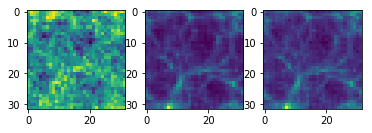

In [8]:
ii = np.random.choice(ntrain)

plt.subplot(131)
plt.imshow(trains[ii].sum(axis=0))
plt.subplot(132)
plt.imshow(traind[ii].sum(axis=0))
plt.subplot(133)
plt.imshow(trainmapp[ii].sum(axis=0))

In [9]:
# tf.reset_default_graph()



# def pm(lin):
#     icstate = tfpm.lptinit(lin, config, name='icstate')
# #     fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
#     final = tf.zeros_like(lin)
#     final = tfpf.cic_paint(final, icstate[0], boxsize=bs, name='final')

#     return final

# inchannnels, outchannels = 1, 1
# hidden_units = 8


# ##################
# xx = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])
# xtrue = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])
# yy = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])


# opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)

# losst = tf.get_variable('loss', initializer=0., trainable=False)
# reset_loss = losst.assign(0)


# hiter, xiter = [], []
# xlin = xx

# losslist = []
# xiter.append(xlin)

# giter = []
# niter = []
# gradloss = []
# fins = []


# W0 = tf.get_variable('W0', shape = [1, 1, 1, 2, 1], trainable=True, initializer=tf.ones_initializer()) 

# # gradloss.append(opt.compute_gradients(losst, [W0]))

# linear = xlin[0,...,0]
# final = pm(linear)
# fins.append(final)

# chisq = tf.reduce_sum(tf.square(tf.subtract(final, tf.squeeze(yy))))/nc**3
# grads = tf.gradients(chisq, [linear])[0]
# giter.append(grads)

# xcat = tf.concat([xlin, tf.expand_dims(tf.expand_dims(grads, 0), -1)], axis=-1)
# net = tf.nn.conv3d(xcat, W0, strides=(1, 1, 1, 1, 1), padding='SAME')
# niter.append(net)

# # net = grads 
# xout = xlin + net
# iloss = tf.reduce_sum((xout - xtrue)**2)/nc**3
# losslist.append(iloss)
# losst = losst + iloss
# xiter.append(xout)

# gradloss.append(opt.compute_gradients(losst, [W0]))

# ########################
# linear2 = (xout[0,...,0])
# final2 = pm(linear2)
# fins.append(final2)
# chisq2 = tf.reduce_sum(tf.square(tf.subtract(final2, tf.squeeze(yy))))/nc**3

# grads2 = tf.gradients(chisq2, [linear2])[0]
# giter.append(grads2)
# xcat2 = tf.concat([xout, tf.expand_dims(tf.expand_dims(grads2, 0), -1)], axis=-1)
# # xcat2 = tf.concat([xout, xout], axis=-1)
# xcat2 = tf.concat([tf.expand_dims(tf.expand_dims(grads2, 0), -1), tf.expand_dims(tf.expand_dims(grads2, 0), -1)], -1)
# net2 = tf.nn.conv3d(xcat2, W0, (1, 1, 1, 1, 1), 'SAME')#slim.conv3d(xcat, inchannnels, 3)
# niter.append(net2)

# # net2 = grads2 
# xout2 = net2 # xout + net2
# iloss2 = tf.reduce_sum((xout2 - xtrue)**2)/nc**3
# losslist.append(iloss)
# losst = losst + iloss2
# xlin2 = xout2
# xiter.append(xlin2)

# gradloss.append(opt.compute_gradients(losst, [W0]))
# opt_op = opt.minimize(losst)




# start = time.time()
# #Train


# sess = tf.Session()    
# sess.run(tf.global_variables_initializer())

# batchsize = 1

# llist = []
# ind = np.random.choice(trains.shape[0], batchsize)
# ind = [0]
# #     sess.run(reset_loss)
# ixx, ixtrue, iyy = traininit[ind], trains[ind], traind[ind]
# ixx, ixtrue, iyy = np.expand_dims(ixx, -1), np.expand_dims(ixtrue, -1), np.expand_dims(iyy, -1)

# for nb in range(2):

#     if nb %10 == 0: print('Step : ', nb, time.time()-start)



#     _, l, ll, ix, inn,  ig, im, gl = sess.run([opt_op, losst, losslist, xiter, niter, giter, fins, gradloss], 
#                                       {xx:ixx, xtrue:ixtrue, yy:iyy})

#     print(l)
#     llist.append(l)

# print(time.time()-start)

Step :  0 0.14673829078674316
12.408873
12.253477
5.2471394538879395


# Diagnostic

In [9]:


def makefig(truemesh, reconmesh, fname, boxsize, title=''):
    '''Given a graph, list of 3 fields in truemesh & recon-init                                                                                                                                                                   
    create the diagnostic figure,  3X3                                                                                                                                                                                            
    '''
    truelin, truefin, truedata = truemesh
    linear, final, data = reconmesh
    fig, ax = plt.subplots(2, 3, figsize = (8, 5))
    meshes = [[truelin, linear], [truefin, final], [truedata, data]]
    labels = ['Linear', 'Final', 'Data']
    for i in range(2):
        m1, m2 = meshes[i][0], meshes[i][1]
        if m1.mean() < 1e-2:
            m1, m2 = m1+1, m2+1
        k, pt = tools.power(m1, boxsize=boxsize)
        k, pr = tools.power(m2, boxsize=boxsize)
        k, px = tools.power(m1, m2, boxsize=boxsize)
        ax[0, 0].semilogx(k, px/(pr*pt)**.5, 'C%d'%i, label=labels[i])
        ax[1, 0].semilogx(k, pr/pt, 'C%d'%i)
#         ax[2+i].loglog(k, pt, 'C%d'%i)
#         ax[0, 2].loglog(k, pr, 'C%d--'%i)
        ax[0, 1+i].imshow(m2.sum(axis=0))
        ax[1, 1+i].imshow(m1.sum(axis=0))
    ax[1, 1].set_ylabel('Truth Linear', fontsize=12)
    ax[0, 1].set_ylabel('Recon Linear', fontsize=12)
    ax[1, 2].set_ylabel('Truth Final', fontsize=12)
    ax[0, 2].set_ylabel('Recon Final', fontsize=12)
    ax[0, 0].set_title('Cross Correlation', fontsize=12)
    ax[0, 0].set_ylim(-0.1, 1.1)
    ax[1, 0].set_title('Transfer Function', fontsize=12)
    ax[1, 0].set_ylim(-0.1, 2)
#     ax[0, 2].set_title('Powers')
#     ax[0, 2].set_ylim(1, 1e5)
    ax[0, 0].legend()
    for axis in ax.flatten(): axis.grid(which='both', lw=0.5, color='gray')
#     fig.suptitle(title)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Gradient Descent with graph and anneal

In [324]:
from tensorflow.contrib.opt import ScipyOptimizerInterface

def graphdm(config, data, sigma=0.01**0.5, maxiter=100, anneal=False, gtol=1e-5):

    bs, nc = config['boxsize'], config['nc']
    kmesh = sum(kk**2 for kk in config['kvec'])**0.5
    priorwt = config['ipklin'](kmesh) * bs ** -3

    g = tf.Graph()

    with g.as_default():

        initlin = tf.placeholder(tf.float32, data.shape, name='initlin')
        linear = tf.get_variable('linmesh', shape=(nc, nc, nc),
                             initializer=tf.random_normal_initializer(), trainable=True)
        initlin_op = linear.assign(initlin, name='initlin_op')
        #PM                                                                                                                                                                                                                       
        icstate = tfpm.lptinit(linear, config, name='icstate')
        fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
        final = tf.zeros_like(linear)
        final = tfpf.cic_paint(final, fnstate[0], boxsize=bs, name='final')

        #   
              #                                                                                                                                                                                                                         
        #Prior                                                                                                                                                                                                                    
        lineark = tfpf.r2c3d(linear, norm=nc**3)
        priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
        prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt))
        prior = tf.multiply(prior, 1/nc**3, name='prior')

        likelihood = tf.subtract(final, data)
        likelihood = tf.multiply(likelihood, 1/sigma)
        ##Anneal                                                                                                                                                                                                                  
        Rsm = tf.placeholder(tf.float32, name='smoothing')

        #annealing is smoothing the difference, before squaring, with gaussian smoothing
        if anneal :
            print('\nAdding annealing part to graph\n')
            Rsm = tf.multiply(Rsm, bs/nc)
            Rsmsq = tf.multiply(Rsm, Rsm)
            smwts = tf.exp(tf.multiply(-kmesh**2, Rsmsq))
            likelihood = tf.squeeze(likelihood)
            likelihoodk = tfpf.r2c3d(likelihood, norm=nc**3)
            likelihoodk = tf.multiply(likelihoodk, tf.cast(smwts, tf.complex64))
            residual = tfpf.c2r3d(likelihoodk, norm=nc**3)
        else:
            residual = tf.identity(likelihood)

        chisq = tf.multiply(residual, residual)
        chisq = tf.reduce_sum(chisq)
        chisq = tf.multiply(chisq, 1/nc**3, name='chisq')

        loss = tf.add(chisq, prior, name='loss')
           
        optimizer = ScipyOptimizerInterface(loss, var_list=[linear], method='L-BFGS-B',
                                            options={'maxiter': maxiter, 'gtol':gtol})

        tf.add_to_collection('inits', [initlin_op, initlin])
        tf.add_to_collection('opt', optimizer)
        tf.add_to_collection('diagnostics', [prior, chisq, loss])
        tf.add_to_collection('reconpm', [linear, final, fnstate])
        tf.add_to_collection('data', data)
    return g


# without anneal

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


Do init

########## No annealing ##########


Checking mode = init



/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


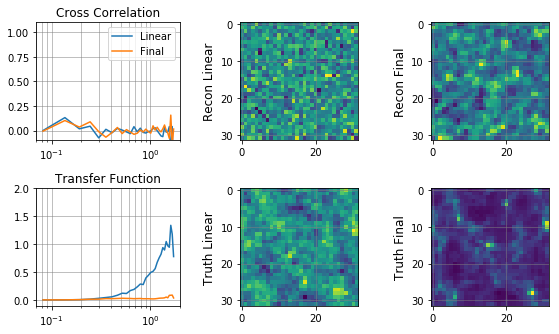

Time taken for iterations 0 =  10.982330799102783
Iteration no. :  0  - Loss, chisq, prior, grad :  [328.36676, 327.88275, 0.48400262, 1.2067823]


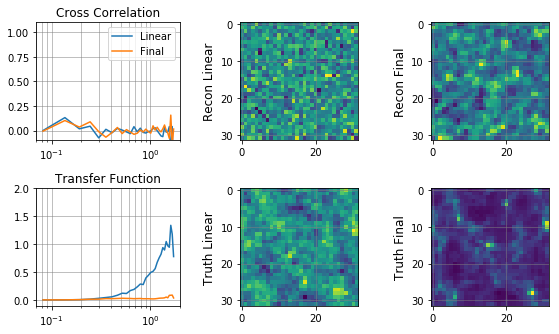

Time taken for iterations 10 =  13.134702205657959
Iteration no. :  10  - Loss, chisq, prior, grad :  [150.48802, 149.99573, 0.49229643, 4.9835424]


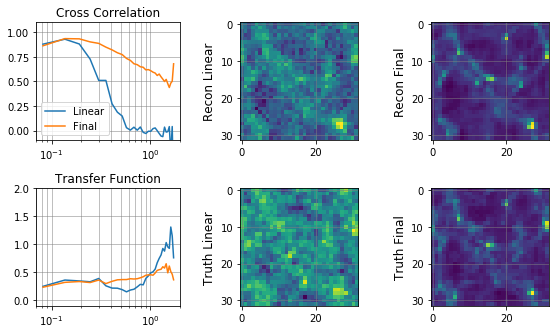

Time taken for iterations 20 =  15.26374077796936
Iteration no. :  20  - Loss, chisq, prior, grad :  [58.6329, 58.114185, 0.5187163, 3.1757903]


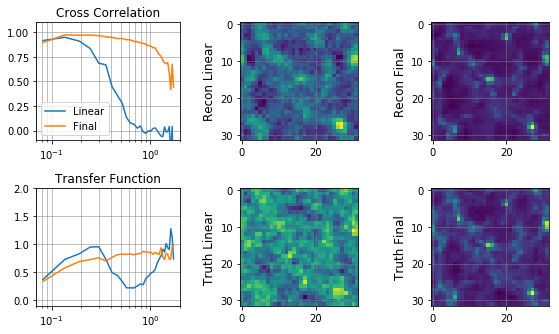

Time taken for iterations 30 =  17.45281171798706
Iteration no. :  30  - Loss, chisq, prior, grad :  [34.469425, 33.928764, 0.5406605, 0.7929915]


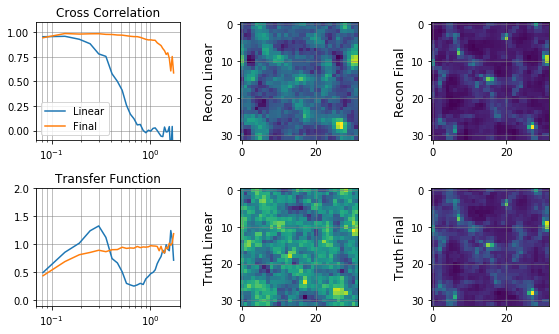

Time taken for iterations 40 =  19.62514328956604
Iteration no. :  40  - Loss, chisq, prior, grad :  [25.735676, 25.181393, 0.55428255, 0.572205]


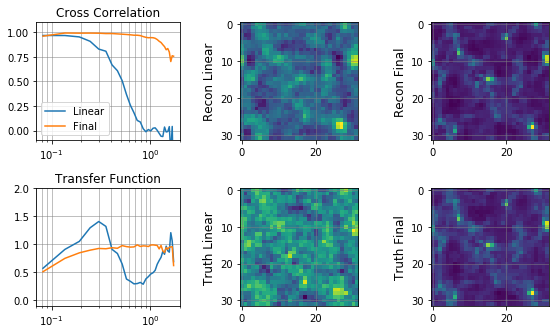

Time taken for iterations 50 =  21.817721605300903
Iteration no. :  50  - Loss, chisq, prior, grad :  [21.017921, 20.453562, 0.5643587, 0.9333989]


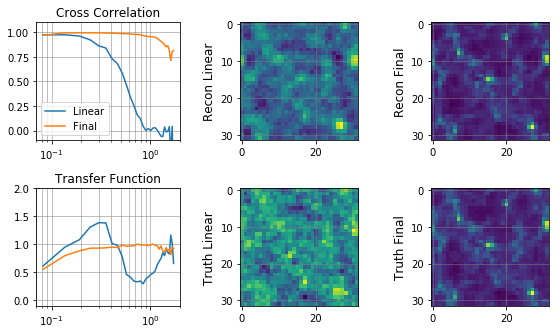

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 19.312563
  Number of iterations: 50
  Number of functions evaluations: 56

Checking mode = recon



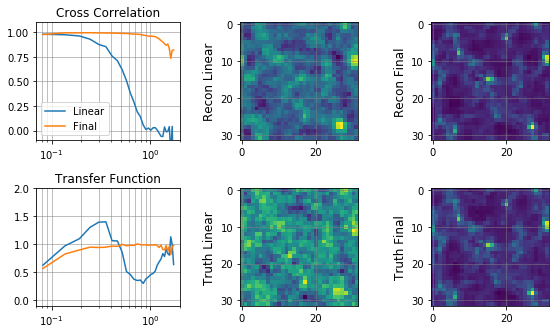

In [83]:
anneal = False
iseed = 0 
truemeshes = [tests[iseed], testd[iseed], testmapp[iseed]]
initval = testinit[iseed]

maxiter = 50
nprint, nsave = 10, 10

def loss_callback(var, literals, nprint=50, nsave=50, maxiter=500, t0=time.time()):
    losses = literals['losses']
    loss = var[0]
    reconmeshes = var[1]
    nit = len(losses) %(maxiter+10)
    losses.append(loss)
    if nit % nprint == 0:
        print('Time taken for iterations %d = '%nit, time.time() - t0)
        print('Iteration no. : ', nit, " - Loss, chisq, prior, grad : ", loss)

        fname = None
        stime = time.time()
        makefig(literals['truemeshes'], reconmeshes, fname, boxsize=bs, title='%s'%loss)




losses = []
literals = {'losses':losses, 'truemeshes':truemeshes, 'bs':bs, 'nc':nc}
tstart = time.time()
lcallback = lambda x: loss_callback(x, literals=literals, nprint=nprint, nsave=nsave, maxiter=maxiter, t0=tstart)
R0s = [4, 2, 1, 0]

#
recong = graphdm(config, truemeshes[-1], maxiter=maxiter, anneal=anneal)
reconfieldsanneal = []

with tf.Session(graph=recong) as session:
    g = session.graph
    session.run(tf.global_variables_initializer())
    linmesh = g.get_tensor_by_name("linmesh:0")
    final = g.get_tensor_by_name("final:0")
    samples = final
    optimizer = g.get_collection_ref('opt')[0]
    loss = g.get_tensor_by_name('loss:0')
    chisq = g.get_tensor_by_name('chisq:0')
    grad = tf.norm(tf.gradients(loss, linmesh))
    prior = g.get_tensor_by_name('prior:0')
    Rsm = g.get_tensor_by_name('smoothing:0')

    if initval is not None:
        print('Do init')
        initlinop = g.get_operation_by_name('initlin_op')
        initlin = g.get_tensor_by_name('initlin:0')
        session.run(initlinop, {initlin:initval})


    def checkiter(mode, optfolder=None, R0=0):
        print('\nChecking mode = %s\n'%mode)
        meshs, meshf, meshd = session.run([linmesh, final, samples], {Rsm:R0})
        title = session.run([loss, chisq, prior, grad], {Rsm:R0})
#         np.save(optfolder + '/%s%d.f4'%(mode, R0), meshs)
        makefig(literals['truemeshes'], [meshs, meshf, meshd], None, 
                   boxsize=bs, title='%s'%title)

    if anneal:

        for R0 in R0s:
            literals = {'losses':[], 'truemeshes':truemeshes, 'bs':bs, 'nc':nc}
            optfolder = None
            print('\n########## Anneal for Rsm = %0.2f ##########\n'%R0)

            checkiter('init', optfolder, R0=R0)
            optimizer.minimize(session, {Rsm:R0}, loss_callback=lcallback, fetches=[[[loss, chisq, prior, grad], \
                                                                       [linmesh, final, samples]]])
            checkiter('recon', optfolder, R0=R0)
            reconfieldsanneal.append(session.run(linmesh, {Rsm:R0}))

    else:
        optfolder = None
        print('\n########## No annealing ##########\n')

        checkiter('init', optfolder, R0=0)
        optimizer.minimize(session, loss_callback=lcallback, fetches=[[[loss, chisq, prior, grad], \
                                                                       [linmesh, final, samples]]])
        checkiter('recon', optfolder, R0=0)
#         reconfields.append(session.run(linmesh, {Rsm:R0}))
#         #                                                                                                                                                                                                                     



# with anneal

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  



Adding annealing part to graph

Do init

########## Anneal for Rsm = 4.00 ##########


Checking mode = init



/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


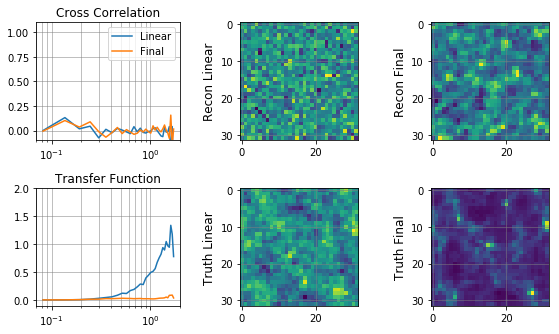

Time taken for iterations 0 =  11.233403205871582
Iteration no. :  0  - Loss, chisq, prior, grad :  [1.4050093, 0.9210067, 0.48400262, 0.044131495]


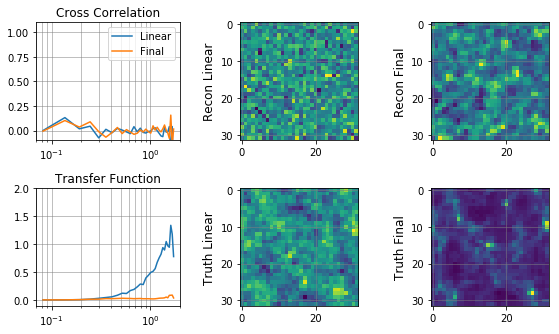

Time taken for iterations 10 =  13.408834218978882
Iteration no. :  10  - Loss, chisq, prior, grad :  [0.09638864, 0.028249219, 0.06813942, 0.0038958362]


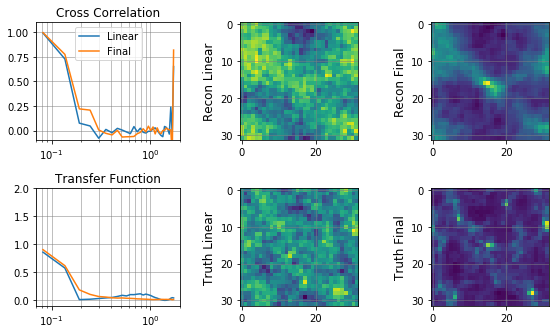

Time taken for iterations 20 =  15.726776361465454
Iteration no. :  20  - Loss, chisq, prior, grad :  [0.011017194, 0.0031238159, 0.007893378, 0.0007185117]


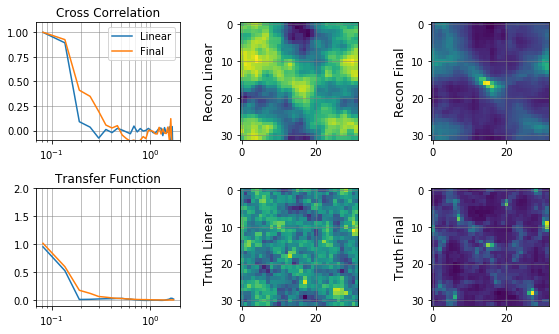

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.004574
  Number of iterations: 27
  Number of functions evaluations: 29

Checking mode = recon



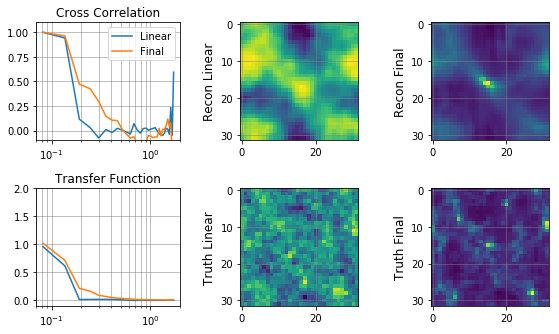


########## Anneal for Rsm = 2.00 ##########


Checking mode = init



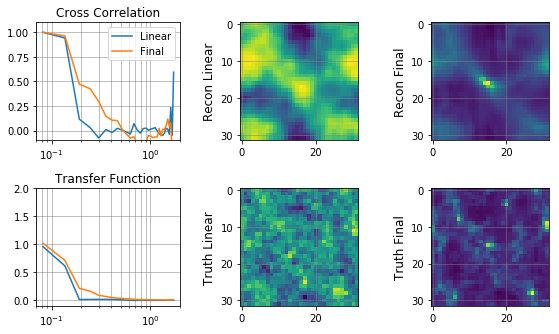

Time taken for iterations 0 =  21.027637243270874
Iteration no. :  0  - Loss, chisq, prior, grad :  [1.0485574, 1.0454547, 0.0031026718, 0.035847493]


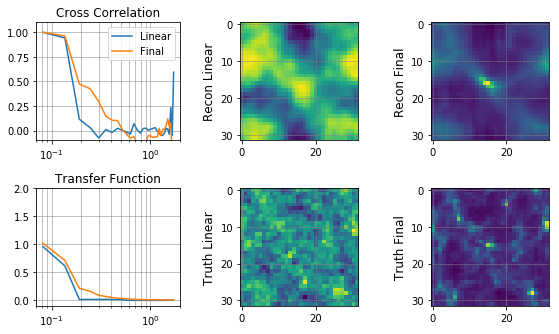

Time taken for iterations 10 =  23.250348567962646
Iteration no. :  10  - Loss, chisq, prior, grad :  [0.06884935, 0.062906444, 0.0059429016, 0.0036957571]


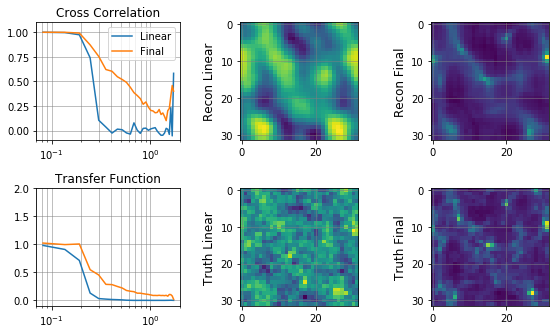

Time taken for iterations 20 =  25.49688148498535
Iteration no. :  20  - Loss, chisq, prior, grad :  [0.025334127, 0.01779858, 0.007535548, 0.0018664609]


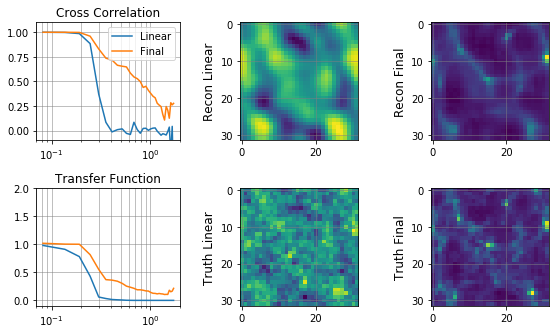

Time taken for iterations 30 =  27.761250495910645
Iteration no. :  30  - Loss, chisq, prior, grad :  [0.01718922, 0.008499158, 0.008690063, 0.0012507354]


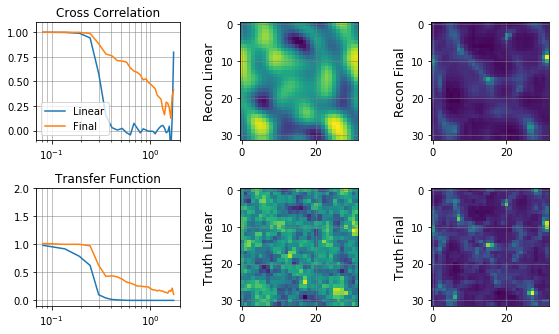

Time taken for iterations 40 =  30.063235759735107
Iteration no. :  40  - Loss, chisq, prior, grad :  [0.013900591, 0.0047748922, 0.009125699, 0.000663101]


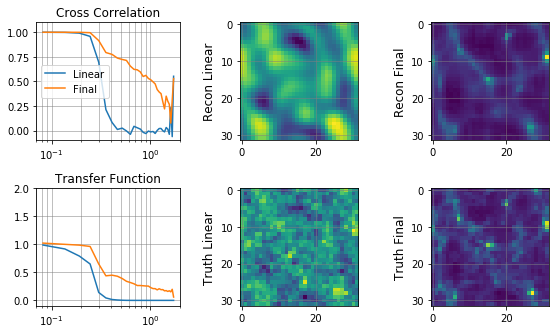

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.013767
  Number of iterations: 40
  Number of functions evaluations: 42

Checking mode = recon



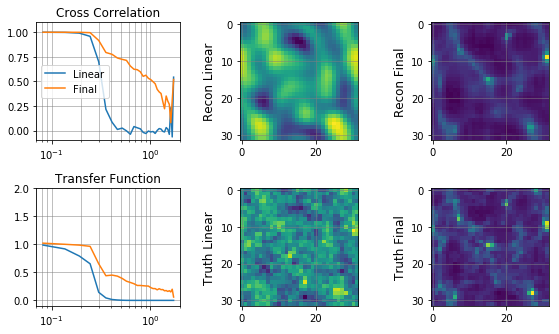


########## Anneal for Rsm = 1.00 ##########


Checking mode = init



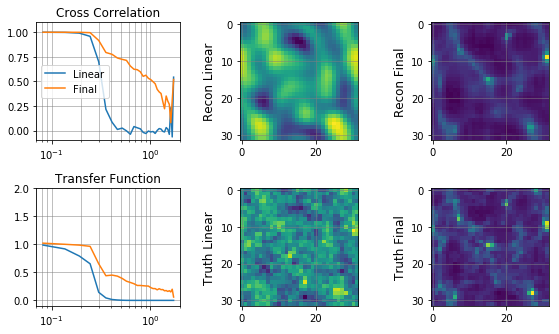

Time taken for iterations 0 =  33.99147129058838
Iteration no. :  0  - Loss, chisq, prior, grad :  [1.9378139, 1.9286497, 0.009164226, 0.06540802]


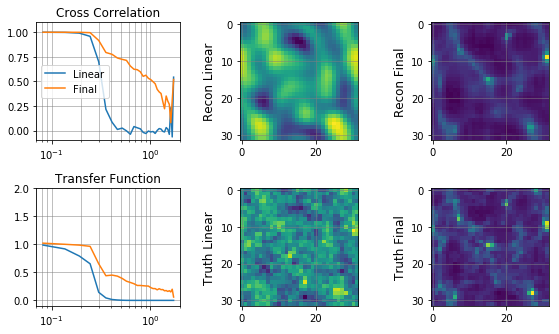

Time taken for iterations 10 =  36.30454349517822
Iteration no. :  10  - Loss, chisq, prior, grad :  [0.3437594, 0.32241493, 0.021344448, 0.02371492]


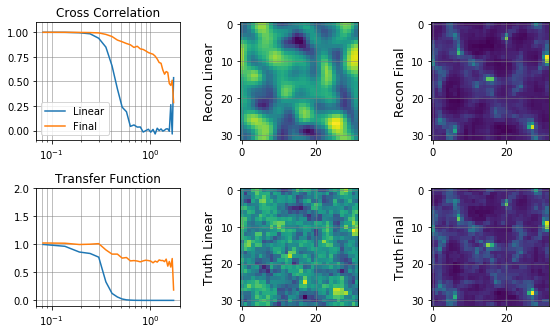

Time taken for iterations 20 =  38.63188600540161
Iteration no. :  20  - Loss, chisq, prior, grad :  [0.1460499, 0.116116546, 0.029933352, 0.009106189]


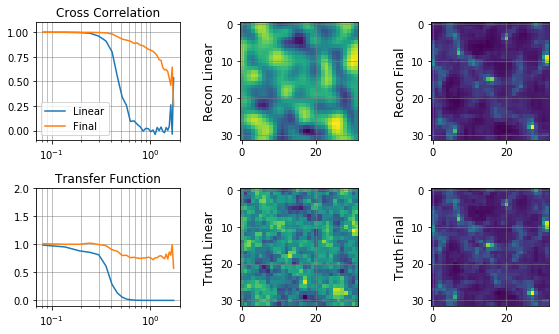

Time taken for iterations 30 =  40.893617153167725
Iteration no. :  30  - Loss, chisq, prior, grad :  [0.096069925, 0.059009798, 0.037060127, 0.008886759]


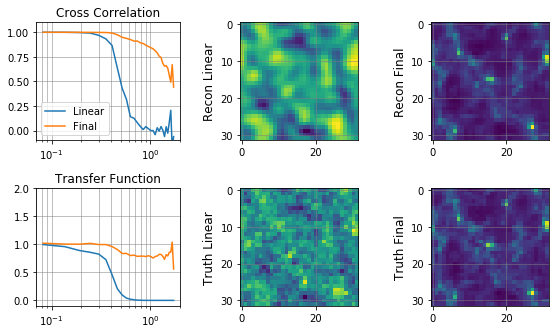

Time taken for iterations 40 =  43.18732953071594
Iteration no. :  40  - Loss, chisq, prior, grad :  [0.07940887, 0.038392164, 0.0410167, 0.0026677486]


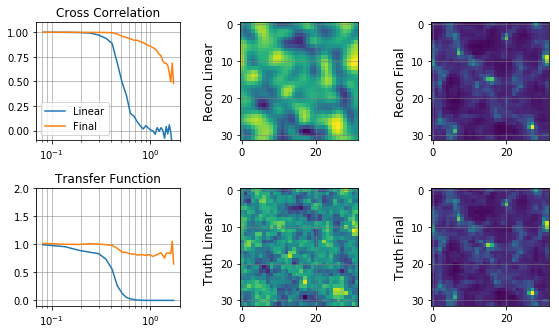

Time taken for iterations 50 =  45.458263635635376
Iteration no. :  50  - Loss, chisq, prior, grad :  [0.07267039, 0.029294508, 0.043375887, 0.0028532995]


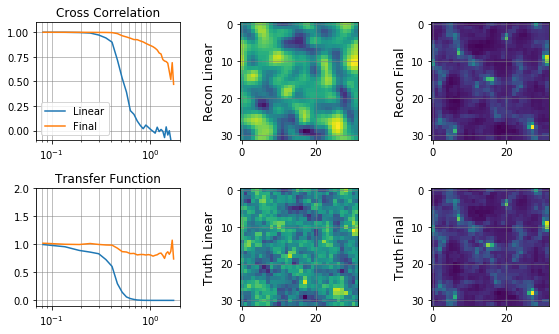

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 0.072145
  Number of iterations: 50
  Number of functions evaluations: 52

Checking mode = recon



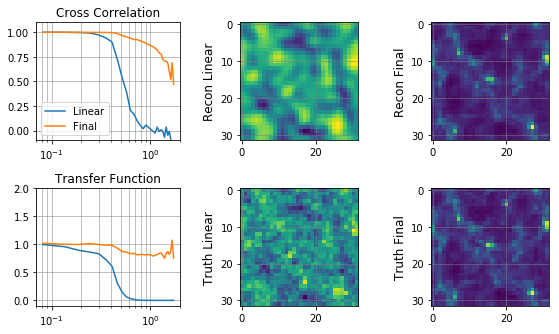


########## Anneal for Rsm = 0.00 ##########


Checking mode = init



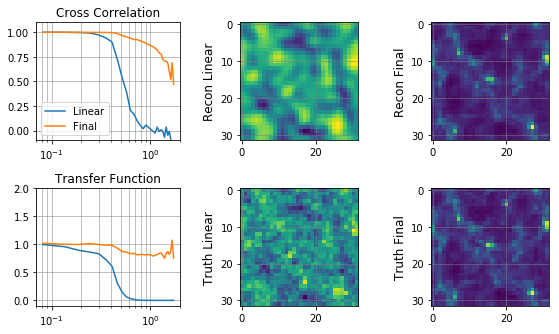

Time taken for iterations 0 =  49.67343044281006
Iteration no. :  0  - Loss, chisq, prior, grad :  [38.93877, 38.895172, 0.043600075, 2.6826663]


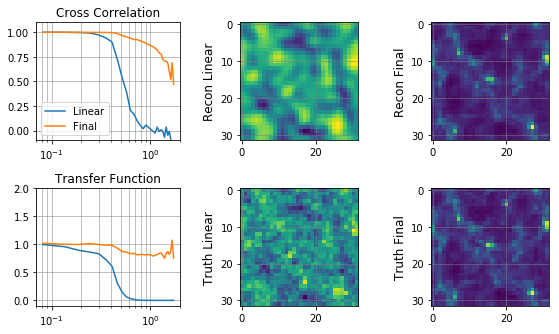

Time taken for iterations 10 =  51.89901947975159
Iteration no. :  10  - Loss, chisq, prior, grad :  [24.835724, 24.78872, 0.047005165, 0.8350097]


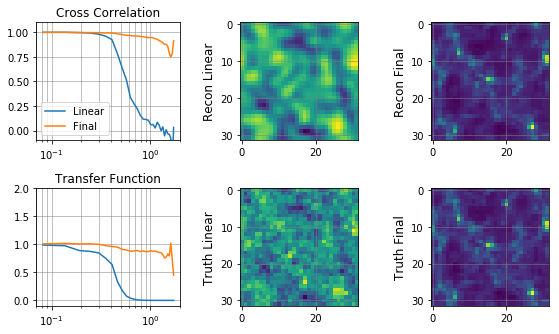

Time taken for iterations 20 =  54.21709632873535
Iteration no. :  20  - Loss, chisq, prior, grad :  [17.985352, 17.926, 0.059350885, 0.5333822]


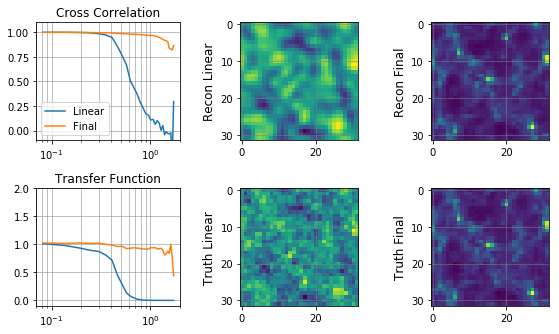

Time taken for iterations 30 =  56.4800341129303
Iteration no. :  30  - Loss, chisq, prior, grad :  [14.05364, 13.973652, 0.07998813, 0.3368609]


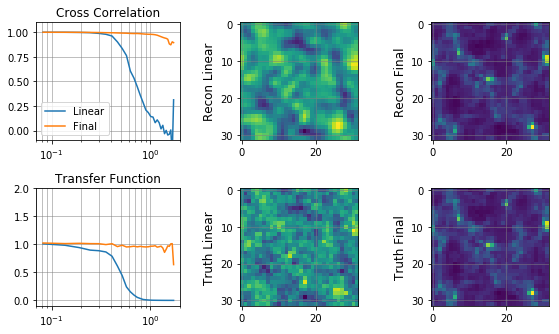

Time taken for iterations 40 =  58.744415044784546
Iteration no. :  40  - Loss, chisq, prior, grad :  [12.142396, 12.040596, 0.1017998, 0.28283194]


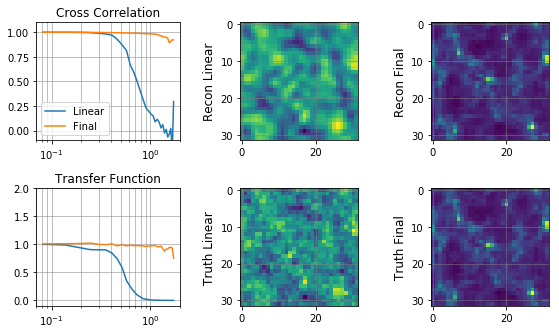

Time taken for iterations 50 =  61.052276611328125
Iteration no. :  50  - Loss, chisq, prior, grad :  [10.886624, 10.76195, 0.12467475, 0.53076047]


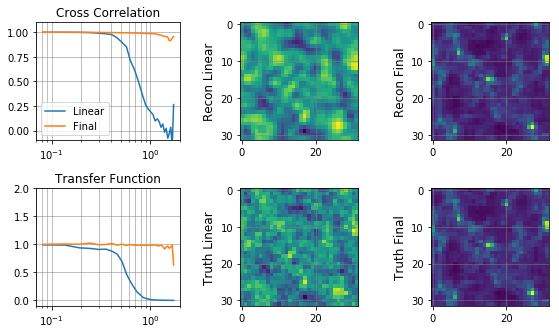

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 10.697224
  Number of iterations: 50
  Number of functions evaluations: 53

Checking mode = recon



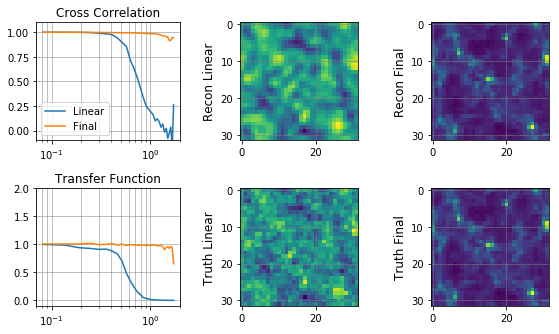

In [86]:
anneal = True
iseed = 0 
truemeshes = [tests[iseed], testd[iseed], testmapp[iseed]]
initval = testinit[iseed]

maxiter = 50
nprint, nsave = 10, 10

def loss_callback(var, literals, nprint=50, nsave=50, maxiter=500, t0=time.time()):
    losses = literals['losses']
    loss = var[0]
    reconmeshes = var[1]
    nit = len(losses) %(maxiter+10)
    losses.append(loss)
    if nit % nprint == 0:
        print('Time taken for iterations %d = '%nit, time.time() - t0)
        print('Iteration no. : ', nit, " - Loss, chisq, prior, grad : ", loss)

        fname = None
        stime = time.time()
        makefig(literals['truemeshes'], reconmeshes, fname, boxsize=bs, title='%s'%loss)



losses = []
literals = {'losses':losses, 'truemeshes':truemeshes[-1], 'bs':bs, 'nc':nc}
tstart = time.time()
lcallback = lambda x: loss_callback(x, literals=literals, nprint=nprint, nsave=nsave, maxiter=maxiter, t0=tstart)
R0s = [4, 2, 1, 0]

#
recong = graphdm(config, truemeshes[-1], maxiter=maxiter, anneal=anneal)
reconfieldsanneal = []

with tf.Session(graph=recong) as session:
    g = session.graph
    session.run(tf.global_variables_initializer())
    linmesh = g.get_tensor_by_name("linmesh:0")
    final = g.get_tensor_by_name("final:0")
    samples = final
    optimizer = g.get_collection_ref('opt')[0]
    loss = g.get_tensor_by_name('loss:0')
    chisq = g.get_tensor_by_name('chisq:0')
    grad = tf.norm(tf.gradients(loss, linmesh))
    prior = g.get_tensor_by_name('prior:0')
    Rsm = g.get_tensor_by_name('smoothing:0')

    if initval is not None:
        print('Do init')
        initlinop = g.get_operation_by_name('initlin_op')
        initlin = g.get_tensor_by_name('initlin:0')
        session.run(initlinop, {initlin:initval})


    def checkiter(mode, optfolder=None, R0=0):
        print('\nChecking mode = %s\n'%mode)
        meshs, meshf, meshd = session.run([linmesh, final, samples], {Rsm:R0})
        title = session.run([loss, chisq, prior, grad], {Rsm:R0})
#         np.save(optfolder + '/%s%d.f4'%(mode, R0), meshs)
        makefig(literals['truemeshes'], [meshs, meshf, meshd], None, 
                   boxsize=bs, title='%s'%title)

    if anneal:

        for R0 in R0s:
            literals = {'losses':[], 'truemeshes':truemeshes, 'bs':bs, 'nc':nc}
            optfolder = None
            print('\n########## Anneal for Rsm = %0.2f ##########\n'%R0)

            checkiter('init', optfolder, R0=R0)
            optimizer.minimize(session, {Rsm:R0}, loss_callback=lcallback, fetches=[[[loss, chisq, prior, grad], \
                                                                       [linmesh, final, samples]]])
            checkiter('recon', optfolder, R0=R0)
            reconfieldsanneal.append(session.run(linmesh, {Rsm:R0}))

    else:
        optfolder = None
        print('\n########## No annealing ##########\n')

        checkiter('init', optfolder, R0=0)
        optimizer.minimize(session, loss_callback=lcallback, fetches=[[[loss, chisq, prior, grad], \
                                                                       [linmesh, final, samples]]])
        checkiter('recon', optfolder, R0=0)
#         reconfields.append(session.run(linmesh, {Rsm:R0}))
#         #                                                                                                                                                                                                                     



# Brute force Gradient Descent to check it works

In [93]:
tf.reset_default_graph()


def pm(lin):
    icstate = tfpm.lptinit(lin, config, name='icstate')
    fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
    final = tf.zeros_like(lin)
    final = tfpf.cic_paint(final, fnstate[0], boxsize=bs, name='final')
    return final


xx = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])
xtrue = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])
yy = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])


linear = tf.get_variable('linmesh', shape=(nc, nc, nc),
            initializer=tf.random_normal_initializer(mean=1.0, stddev=0.5), trainable=True)
initlin_op = linear.assign(xx[0,..., 0], name='initlin_op')

final = pm(linear)

lineark = tfpf.r2c3d(linear, norm=nc**3)
priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt))
prior = tf.multiply(prior, 1/nc**3, name='prior')

likelihood = tf.subtract(final, tf.squeeze(yy))
residual = tf.multiply(likelihood, 1/sigma)

chisq = tf.multiply(residual, residual)
chisq = tf.reduce_sum(chisq)
chisq = tf.multiply(chisq, 1/nc**3, name='chisq')

logposterior = tf.add(chisq, prior, name='logposterior')

# grads = tf.gradients(logposterior, [linear])[0]


grads = opt.compute_gradients(logposterior, [linear])

opt = tf.train.AdamOptimizer(learning_rate=0.1)

applygrads = opt.apply_gradients(grads)


In [135]:
# tf.reset_default_graph()


# def pm(lin):
#     icstate = tfpm.lptinit(lin, config, name='icstate')
#     fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
#     final = tf.zeros_like(lin)
#     final = tfpf.cic_paint(final, fnstate[0], boxsize=bs, name='final')
#     return final


# xx = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])
# xtrue = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])
# yy = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])


# W0 = tf.get_variable('W0', shape = [1, 1, 1, 1, 1], trainable=True, initializer=tf.ones_initializer()) 
# W1 = tf.get_variable('W1', shape = [1, 1, 1, 1, 1], trainable=True, initializer=tf.ones_initializer()) 


# net = tf.nn.conv3d(xx, W0, strides=(1, 1, 1, 1, 1), padding='SAME')
# linear = net[0,..., 0]
# final = pm(linear)
# final2 = tf.expand_dims(tf.expand_dims(final, 0), -1)
# gradpm = tf.gradients(final2, linear)[0]
# gradpm = pm(gradpm)
# gradpm = tf.expand_dims(tf.expand_dims(gradpm, 0), -1)
# # net2 = tf.nn.conv3d(final2, W1, strides=(1, 1, 1, 1, 1), padding='SAME')
# net2 = tf.nn.conv3d(gradpm, W0, strides=(1, 1, 1, 1, 1), padding='SAME')
# print(net2)
# losst = tf.reduce_sum(net2**2)

# grads0 = tf.gradients(losst, [W0])
# grads1 = tf.gradients(losst, [W0])

# opt = tf.train.AdamOptimizer(learning_rate=0.1)
# opt_op = opt.minimize(losst)
# # applygrads = opt.apply_gradients(grads)


Tensor("Conv3D_1:0", shape=(1, 32, 32, 32, 1), dtype=float32)


In [99]:
start = time.time()
#Train

# with tf.Session() as sess:
sess = tf.Session()    
sess.run(tf.global_variables_initializer())

batchsize = 1

ind = [0]
ixx, ixtrue, iyy = traininit[ind], trains[ind], traind[ind]
ixx, ixtrue, iyy = np.expand_dims(ixx, -1), np.expand_dims(ixtrue, -1), np.expand_dims(iyy, -1)

# sess.run([grads0, grads1], {xx:ixx, xtrue:ixtrue, yy:iyy})
# # sess.run(opt, {xx:ixx, xtrue:ixtrue, yy:iyy})

for i in range(50):
#     _ = sess.run(opt_op, {xx:ixx, xtrue:ixtrue, yy:iyy})
    _ = sess.run(applygrads, {xx:ixx, xtrue:ixtrue, yy:iyy})

print(time.time()-start)

4.661533832550049


In [100]:
test = sess.run(linear, {xx:ixx, xtrue:ixtrue, yy:iyy})

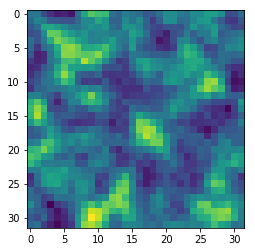

In [101]:
plt.imshow(test.sum(axis=0))

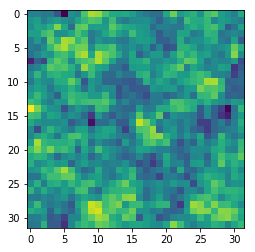

In [102]:
plt.imshow(trains[ind][0].sum(axis=0))

# RIM

In [9]:
# https://github.com/kaustubhhiware/LSTM-GRU-from-scratch/blob/80eb6bca2192e40dd718c6c7bd8830119d78a620/module.py
    
class GRU_cell3D(object):


    def __init__(self, name, input_channels, hidden_units, output_channels, kernel=3, strides=1):

        self.kernel = kernel
        self.strides = [strides, strides, strides, strides, strides]
        self.input_channels = input_channels
        self.hidden_units = hidden_units
        self.output_channels = output_channels
        self.name = name
        
        k_h, k_w, k_z = [kernel]*3
        fan_in = k_h * k_w * k_z * input_channels
        stddev = tf.sqrt(2. / (fan_in))
        n_out = output_channels
        print(stddev)
        self.initializer = tf.truncated_normal_initializer(stddev=stddev)
#         self.initializer = tf.ones_initializer()
        self.zeroinitializer = tf.zeros_initializer()
#         self.zeroinitializer = tf.truncated_normal_initializer(stddev=stddev)
        #
        #
        self.Wx = tf.get_variable(name=name+'/Wx', 
                shape = [self.kernel, self.kernel, self.kernel, self.input_channels, self.hidden_units], 
                initializer =self.zeroinitializer, trainable=True) #maybe 0 init is better?
        self.Wr = tf.get_variable(name=name+'/Wr', 
                shape = [self.kernel, self.kernel, self.kernel, self.input_channels, self.hidden_units], 
                initializer =self.zeroinitializer, trainable=True) #maybe 0 init is better?
        self.Wz = tf.get_variable(name=name+'/Wz', 
                shape = [self.kernel, self.kernel, self.kernel, self.input_channels, self.hidden_units], 
                initializer =self.zeroinitializer, trainable=True) #maybe 0 init is better?
        self.Wh = tf.get_variable(name=name+'/Wh', 
                shape = [self.kernel, self.kernel, self.kernel, self.hidden_units, self.hidden_units], 
                initializer =self.zeroinitializer, trainable=True) #maybe 0 init is better?
        self.Wo = tf.get_variable(name=name+'/Wo', 
                shape = [self.kernel, self.kernel, self.kernel, self.hidden_units, self.output_channels], 
                initializer =self.initializer, trainable=True) 
        
        self.br = tf.get_variable(name=name+'/br', shape = [self.hidden_units], 
                initializer =self.initializer, trainable=True)
        self.bz = tf.get_variable(name=name+'/bz', shape = [self.hidden_units], 
                initializer =self.initializer, trainable=True)
        self.bo = tf.get_variable(name=name+'/bo', shape = [self.output_channels], 
                initializer =self.initializer, trainable=True)

        
        self.initial_hidden = tf.placeholder(name='initialhidden', dtype=tf.float32,
                shape=[None, None, None, None, self.hidden_units])

        
    def Gru(self, previous_hidden_state, x):

        z = tf.sigmoid(tf.nn.conv3d(x, self.Wz, strides=self.strides, padding='SAME') + self.bz)
        r = tf.sigmoid(tf.nn.conv3d(x, self.Wr, strides=self.strides, padding='SAME') + self.br)

        h_ = tf.tanh(tf.nn.conv3d(x, self.Wx, strides=self.strides, padding='SAME') +
            tf.nn.conv3d(previous_hidden_state, self.Wh, strides=self.strides,padding='SAME')*r)

        current_hidden_state = tf.multiply( (1 - z), h_) + tf.multiply(previous_hidden_state, z)

        return current_hidden_state

    def get_output(self, hidden_state):
#         output = tf.nn.leaky_relu(tf.nn.conv3d(hidden_state, self.Wo, 
#                                 strides=self.strides, padding='SAME') + self.bo)
        output = (tf.nn.conv3d(hidden_state, self.Wo, 
                                strides=self.strides, padding='SAME') + self.bo)
        return output



In [79]:
tf.reset_default_graph()


def pm(lin):
    icstate = tfpm.lptinit(lin, config, name='icstate')
    fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
    final = tf.zeros_like(lin)
    final = tfpf.cic_paint(final, fnstate[0], boxsize=bs, name='final')
    return final

inchannnels, outchannels = 1, 8
hidden_units = 32


xx = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])
xtrue = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])
yy = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])
lr = tf.placeholder(tf.float32)

opt = tf.train.GradientDescentOptimizer(learning_rate=lr)

mygru3d = GRU_cell3D('mygru', inchannnels*2, hidden_units, outchannels)
hidden = mygru3d.initial_hidden

losst = tf.get_variable('loss', initializer=0., trainable=False)
reset_loss = losst.assign(0)


hiter, xiter = [], []
xlin = xx
losslist = []
xiter.append(xlin)
hiter.append(hidden)
giter = []
niter = []

W0 = tf.get_variable('W0', shape = [3, 3, 3, 2, 2], trainable=True) 
W1 = tf.get_variable('W1', shape = [3, 3, 3, outchannels, 1], trainable=True) 
# W2 = tf.get_variable('W2', shape = [3, 3, 3, outchannels, 1], trainable=True) 

for i in range(10):

    linear = tf.stop_gradient(xlin[0,...,0])
    final = pm(linear)
    
    likelihood = tf.subtract(final, tf.squeeze(yy))
    residual = tf.multiply(likelihood, 1/sigma)

    chisq = tf.multiply(residual, residual)
    chisq = tf.reduce_sum(chisq)
    chisq = tf.multiply(chisq, 1/nc**3, name='chisq')
#     grads = opt.compute_gradients(chisq, [linear])[0][0]

    lineark = tfpf.r2c3d(linear, norm=nc**3)
    priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
    prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt))
    prior = tf.multiply(prior, 1/nc**3, name='prior')

    logposterior = tf.add(chisq, prior, name='logposterior')
#     grads = tf.gradients(logposterior, [xlin])[0]
    grads = tf.gradients(logposterior, [linear])[0]*10

    giter.append(grads)
    xcat = tf.concat([xlin, tf.expand_dims(tf.expand_dims(grads, 0), -1)], axis=-1)
#     xcat = tf.concat([xlin, grads], axis=-1)
    net = tf.nn.conv3d(xcat, W0, strides=(1, 1, 1, 1, 1), padding='SAME')
    
    hidden = mygru3d.Gru(hidden, net)
    hiter.append(hidden)

    net = mygru3d.get_output(hidden)
    net = tf.nn.tanh(tf.nn.conv3d(net, W1, strides=(1, 1, 1, 1, 1), padding='SAME'))
#     net = (tf.nn.conv3d(net, W1, strides=(1, 1, 1, 1, 1), padding='SAME'))
    niter.append(net)

    xout = xlin + net
    iloss = tf.reduce_mean((xout - xtrue)**2)
    losslist.append(iloss)
    losst = losst + iloss
    xlin = xout
    xiter.append(xlin)

opt_op = opt.minimize(losst)


Tensor("Sqrt:0", shape=(), dtype=float32)


In [67]:
#### Implementation with gradients in Fourier domain

# tf.reset_default_graph()


# def pm(lin):
#     lin = tf.cast(lin, tf.complex64)
#     lin = lin[...,0] + 1j*lin[...,1]
#     lin = tf.cast(tf.spectral.ifft3d(lin), tf.float32)

#     icstate = tfpm.lptinit(linear=lin,config=config, name='icstate')
#     fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
#     final = tf.cast(tf.zeros_like(lin), tf.float32)
#     final = tfpf.cic_paint(final, fnstate[0], boxsize=bs, name='final')
#     return final

# inchannnels, outchannels = 2, 8
# hidden_units = 32


# xx = tf.placeholder(tf.float32, [1, nc, nc, nc, 1])
# xtrue = tf.placeholder(tf.float32, [1, nc, nc, nc, 1])
# yy = tf.placeholder(tf.float32, [1, nc, nc, nc, 1])
# lr = tf.placeholder(tf.float32)

# opt = tf.train.GradientDescentOptimizer(learning_rate=lr)

# mygru3d = GRU_cell3D('mygru', inchannnels*2, hidden_units, outchannels)
# hidden = mygru3d.initial_hidden

# losst = tf.get_variable('loss', initializer=0., trainable=False)
# reset_loss = losst.assign(0)


# hiter, xiter = [], []
# xlin = xx
# losslist = []
# xiter.append(xlin)
# hiter.append(hidden)
# giter = []
# niter = []

# W0 = tf.get_variable('W0', shape = [1, 1, 1, 4, 4], trainable=True) 
# W1 = tf.get_variable('W1', shape = [1, 1, 1, outchannels, 2], trainable=True) 
# # W2 = tf.get_variable('W2', shape = [3, 3, 3, outchannels, 1], trainable=True) 

# for i in range(5):

#     linear = tf.stop_gradient(xlin[0,...,0])
#     linearc = tf.spectral.fft3d(tf.cast(linear, tf.complex64))
#     linearc = tf.stack([tf.real(linearc), tf.imag(linearc)], axis=-1)
#     final = pm(linearc)
    
#     likelihood = tf.subtract(final, tf.squeeze(yy))
#     residual = tf.multiply(likelihood, 1/sigma)

#     chisq = tf.multiply(residual, residual)
#     chisq = tf.reduce_sum(chisq)
#     chisq = tf.multiply(chisq, 1/nc**3, name='chisq')

#     lineark = tfpf.r2c3d(linear, norm=nc**3)
#     priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
#     prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt))
#     prior = tf.multiply(prior, 1/nc**3, name='prior')

#     logposterior = tf.add(chisq, prior, name='logposterior')
#     grads = tf.gradients(logposterior, [linearc])[0]
#     giter.append(grads)

#     xcat = tf.concat([linearc, grads], axis=-1)
#     xcat = tf.expand_dims(xcat, 0)
    
    
#     net = tf.nn.conv3d(xcat, W0, strides=(1, 1, 1, 1, 1), padding='SAME')
    
#     hidden = mygru3d.Gru(hidden, net)
#     hiter.append(hidden)

#     net = mygru3d.get_output(hidden)
#     net = tf.nn.tanh(tf.nn.conv3d(net, W1, strides=(1, 1, 1, 1, 1), padding='SAME'))
# #     net = (tf.nn.conv3d(net, W1, strides=(1, 1, 1, 1, 1), padding='SAME'))
#     niter.append(net)
    
#     linearc = tf.cast(linearc + net, tf.complex64)
#     linearc = linearc[...,0] + 1j*linearc[...,1]    
#     xout = tf.expand_dims(tf.cast(tf.spectral.ifft3d(linearc), tf.float32), -1)
#     iloss = tf.reduce_mean((xout - xtrue)**2)
#     losslist.append(iloss)
#     losst = losst + iloss
#     xlin = xout
#     xiter.append(xlin)

# opt_op = opt.minimize(losst)


Tensor("Sqrt:0", shape=(), dtype=float32)


In [80]:
start = time.time()
#Train


sess = tf.Session()    
sess.run(tf.global_variables_initializer())
llist = []

batchsize = 1

zerohidden = np.zeros((batchsize, nc, nc, nc, hidden_units)).astype(float32)

for nb in range(100):

    ind = np.random.choice(trains.shape[0], batchsize)
#     ind = [0]
    sess.run(reset_loss)
    ixx, ixtrue, iyy = traininit[ind], trains[ind], traind[ind]
    ixx, ixtrue, iyy = np.expand_dims(ixx, -1), np.expand_dims(ixtrue, -1), np.expand_dims(iyy, -1)

    _, l, ll, ix, inn, ih, ig = sess.run([opt_op, losst, losslist, xiter, niter, hiter, giter], 
                                      {xx:ixx, xtrue:ixtrue, yy:iyy, mygru3d.initial_hidden:zerohidden, 
                                      lr:0.05})

    if nb %50 == 0: 
        print('Step : ', nb, ' Loss : ', l)
#     print(l)
    llist.append(l)

print(time.time()-start)

Step :  0  Loss :  68.873665
Step :  50  Loss :  nan
111.8972339630127


[]

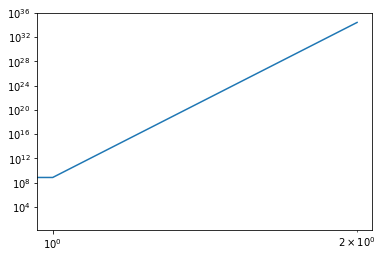

In [81]:
plt.plot(llist)
plt.loglog()

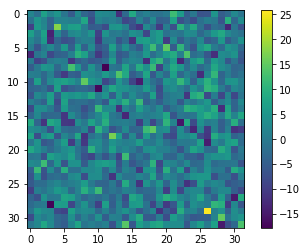

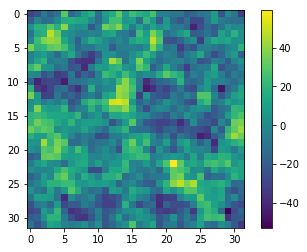

In [82]:
plt.imshow(np.squeeze(ix[0]).sum(axis=0))
plt.colorbar()
plt.show()
plt.imshow(np.squeeze(ixtrue).sum(axis=0))
plt.colorbar()
plt.show()


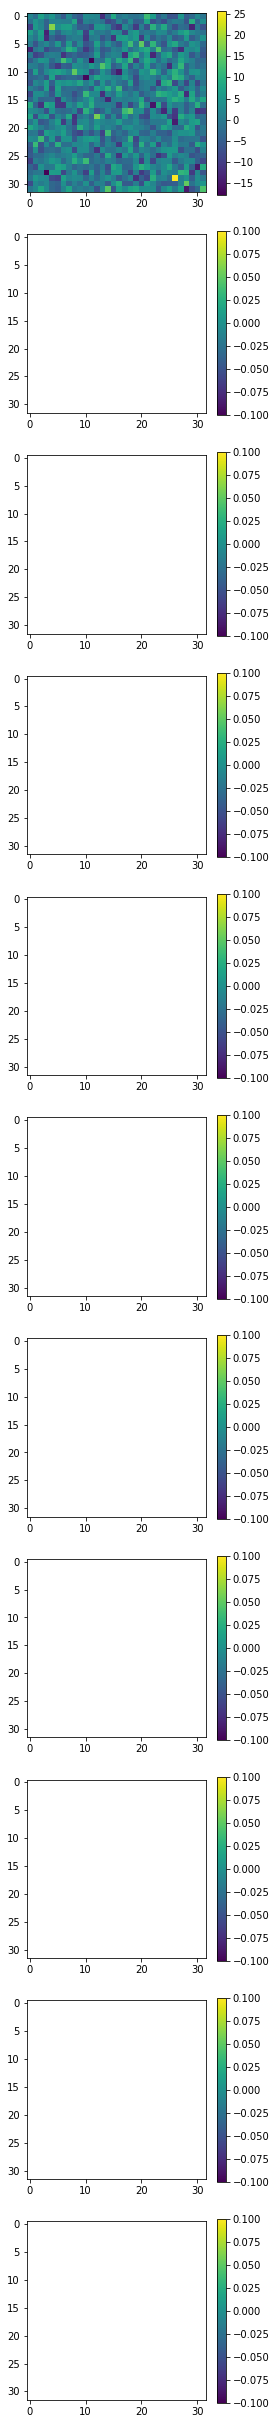

In [83]:
xsize = len(ix)
plt.figure(figsize = (4, xsize*4))
for i in range(xsize):
    plt.subplot( xsize,1, i+1)
    plt.imshow(np.squeeze(ix[i]).sum(axis=0))
    plt.colorbar()    

In [84]:
ix[0]/ixtrue[0]

array([[[[[ 3.29244971e-01],
          [-1.07352554e+00],
          [ 5.36162652e-01],
          ...,
          [ 1.10133574e-01],
          [ 5.71280580e-01],
          [-3.08467514e-01]],

         [[-2.81627284e-01],
          [ 3.59922620e-03],
          [ 2.42095417e-02],
          ...,
          [ 2.73568773e-01],
          [ 1.40755596e+00],
          [-2.36610719e-01]],

         [[-1.17772416e-01],
          [ 1.29550865e-01],
          [ 1.31444591e-01],
          ...,
          [ 4.61850202e-01],
          [ 2.19037940e+00],
          [ 3.66116429e-01]],

         ...,

         [[ 2.12055527e-01],
          [-8.64746257e-01],
          [-9.27499900e-02],
          ...,
          [ 9.88317677e-01],
          [ 7.55979757e-02],
          [-6.71323698e-01]],

         [[ 3.71335389e-01],
          [ 2.55732130e-01],
          [-8.84695940e-01],
          ...,
          [ 6.75610470e-02],
          [ 8.55717293e-02],
          [ 5.98791552e-01]],

         [[ 5.16057159e-02],
 

In [85]:
ix[0]/ix[-1]

array([[[[[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         [[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         [[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         ...,

         [[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         [[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         [[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]]],


        [[[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         [[nan],
          [nan],
          [nan],
          ...,
          [nan],
          [nan],
          [nan]],

         [[nan],
          [nan

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 3.2763e+04, 2.0000e+00]),
 array([-2753.6765 , -2423.2888 , -2092.9011 , -1762.5134 , -1432.1257 ,
        -1101.738  ,  -771.3503 ,  -440.96255,  -110.57485,   219.81285,
          550.20056], dtype=float32),
 <a list of 10 Patch objects>)

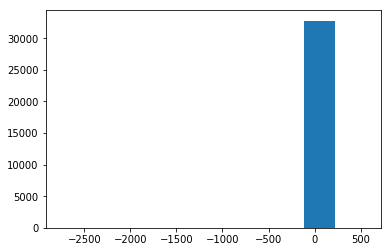

In [56]:
plt.hist((ix[0]/ix[-1]).flatten())

# DEBUG

In [107]:
tf.reset_default_graph()



def pm(lin):
    icstate = tfpm.lptinit(lin, config, name='icstate')
#     fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
    final = tf.zeros_like(lin)
    final = tfpf.cic_paint(final, icstate[0], boxsize=bs, name='final')

    return final

inchannnels, outchannels = 1, 1
hidden_units = 8


##################
xx = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])
xtrue = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])
yy = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])


opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)

losst = tf.get_variable('loss', initializer=0., trainable=False)
reset_loss = losst.assign(0)


hiter, xiter = [], []
xlin = xx

losslist = []
xiter.append(xlin)

giter = []
niter = []
gradloss = []
fins = []


W0 = tf.get_variable('W0', shape = [1, 1, 1, 2, 1], trainable=True, initializer=tf.ones_initializer()) 

# gradloss.append(opt.compute_gradients(losst, [W0]))

linear = xlin[0,...,0]

final = pm(linear)
fins.append(final)

chisq = tf.reduce_sum(tf.square(tf.subtract(final, tf.squeeze(yy))))/nc**3
grads = tf.gradients(chisq, [linear])[0]
giter.append(grads)

xcat = tf.concat([xlin, tf.expand_dims(tf.expand_dims(grads, 0), -1)], axis=-1)
net = tf.nn.conv3d(xcat, W0, strides=(1, 1, 1, 1, 1), padding='SAME')
niter.append(net)

# net = grads 
xout = xlin + net
iloss = tf.reduce_sum((xout - xtrue)**2)/nc**3
losslist.append(iloss)
losst = losst + iloss
xiter.append(xout)

gradloss.append(opt.compute_gradients(losst, [W0]))

########################
linear2 = (xout[0,...,0])
final2 = pm(linear2)
fins.append(final2)
chisq2 = tf.reduce_sum(tf.square(tf.subtract(final2, tf.squeeze(yy))))/nc**3

grads2 = tf.gradients(chisq2, [linear2])[0]
giter.append(grads2)
xcat2 = tf.concat([xout, tf.expand_dims(tf.expand_dims(grads2, 0), -1)], axis=-1)
# xcat2 = tf.concat([xout, xout], axis=-1)
xcat2 = tf.concat([tf.expand_dims(tf.expand_dims(grads2, 0), -1), tf.expand_dims(tf.expand_dims(grads2, 0), -1)], -1)
net2 = tf.nn.conv3d(xcat2, W0, (1, 1, 1, 1, 1), 'SAME')#slim.conv3d(xcat, inchannnels, 3)
niter.append(net2)

# net2 = grads2 
xout2 = net2 # xout + net2
iloss2 = tf.reduce_sum((xout2 - xtrue)**2)/nc**3
losslist.append(iloss)
losst = losst + iloss2
xlin2 = xout2
xiter.append(xlin2)

gradloss.append(opt.compute_gradients(losst, [W0]))
opt_op = opt.minimize(losst)




start = time.time()
#Train


sess = tf.Session()    
sess.run(tf.global_variables_initializer())

batchsize = 1

llist = []
ind = np.random.choice(trains.shape[0], batchsize)
ind = [0]
#     sess.run(reset_loss)
ixx, ixtrue, iyy = traininit[ind], trains[ind], traind[ind]
ixx, ixtrue, iyy = np.expand_dims(ixx, -1), np.expand_dims(ixtrue, -1), np.expand_dims(iyy, -1)

for nb in range(2):

    if nb %10 == 0: print('Step : ', nb, time.time()-start)



    _, l, ll, ix, inn,  ig, im, gl = sess.run([opt_op, losst, losslist, xiter, niter, giter, fins, gradloss], 
                                      {xx:ixx, xtrue:ixtrue, yy:iyy})
#     l, ll, ix, inn,  ig, im, gl = sess.run([losst, losslist, xiter, niter, giter, fins, gradloss], 
#                                       {xx:ixx, xtrue:ixtrue, yy:iyy})
 
    print(l)
#     sess.run(reset_loss)
    llist.append(l)

print(time.time()-start)

Step :  0 0.32286930084228516
12.407138
nan
4.229672431945801


In [139]:
tf.reset_default_graph()



def pm(lin):
    icstate = tfpm.lptinit(lin, config, name='icstate')
#     fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
    final = tf.zeros_like(lin)
    final = tfpf.cic_paint(final, icstate[0], boxsize=bs, name='final')

    return final

inchannnels, outchannels = 1, 1
hidden_units = 8


##################
xx = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])
xtrue = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])
yy = tf.placeholder(tf.float32, [1, nc, nc, nc, inchannnels])


opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)

losst = tf.get_variable('loss', initializer=0., trainable=False)
reset_loss = losst.assign(0)


hiter, xiter = [], []
xlin = xx

losslist = []
xiter.append(xlin)

giter = []
niter = []
gradloss = []
fins = []


W0 = tf.get_variable('W0', shape = [1, 1, 1, 2, 1], trainable=True, initializer=tf.ones_initializer()) 

# gradloss.append(opt.compute_gradients(losst, [W0]))

linear = xlin[0,...,0]
linearc = tf.spectral.fft3d(tf.cast(linear, tf.complex128))
linearc2 = tf.stack([tf.real(linearc), tf.imag(linearc)], axis=-1)
linear2 = tf.cast(tf.spectral.ifft3d(linearc), tf.float32)
# final = pm(linear)
# fins.append(final)

# chisq = tf.reduce_sum(tf.square(tf.subtract(final, tf.squeeze(yy))))/nc**3
# grads = tf.gradients(chisq, [linear])[0]
# giter.append(grads)

# xcat = tf.concat([xlin, tf.expand_dims(tf.expand_dims(grads, 0), -1)], axis=-1)
# net = tf.nn.conv3d(xcat, W0, strides=(1, 1, 1, 1, 1), padding='SAME')
# niter.append(net)

# # net = grads 
# xout = xlin + net
# iloss = tf.reduce_sum((xout - xtrue)**2)/nc**3
# losslist.append(iloss)
# losst = losst + iloss
# xiter.append(xout)

# gradloss.append(opt.compute_gradients(losst, [W0]))





start = time.time()
#Train


sess = tf.Session()    
sess.run(tf.global_variables_initializer())

batchsize = 1

llist = []
ind = np.random.choice(trains.shape[0], batchsize)
ind = [0]
#     sess.run(reset_loss)
ixx, ixtrue, iyy = traininit[ind], trains[ind], traind[ind]
ixx, ixtrue, iyy = np.expand_dims(ixx, -1), np.expand_dims(ixtrue, -1), np.expand_dims(iyy, -1)


l, lc, l2 = sess.run([linear, linearc2, linear2], {xx:ixx, xtrue:ixtrue, yy:iyy})



In [34]:
start = time.time()
#Train


sess = tf.Session()    
sess.run(tf.global_variables_initializer())

batchsize = 1

llist = []
ind = np.random.choice(trains.shape[0], batchsize)
ind = [0]
#     sess.run(reset_loss)
ixx, ixtrue, iyy = traininit[ind], trains[ind], traind[ind]
ixx, ixtrue, iyy = np.expand_dims(ixx, -1), np.expand_dims(ixtrue, -1), np.expand_dims(iyy, -1)

for nb in range(2):

    if nb %10 == 0: print('Step : ', nb, time.time()-start)



    _, l, ll, ix, inn,  ig, im, gl = sess.run([opt_op, losst, losslist, xiter, niter, giter, fins, gradloss], 
                                      {xx:ixx, xtrue:ixtrue, yy:iyy})
#     l, ll, ix, inn,  ig, im, gl = sess.run([losst, losslist, xiter, niter, giter, fins, gradloss], 
#                                       {xx:ixx, xtrue:ixtrue, yy:iyy})
 
    print(l)
#     sess.run(reset_loss)
    llist.append(l)

print(time.time()-start)

Step :  0 0.14154911041259766
12.40714
nan
5.106953382492065


In [90]:
gl

(array([4.000e+00, 4.100e+01, 2.760e+02, 1.152e+03, 3.555e+03, 7.793e+03,
        1.214e+04, 6.866e+03, 8.900e+02, 5.100e+01]),
 array([0.9719887 , 0.97658265, 0.9811766 , 0.98577064, 0.9903646 ,
        0.9949586 , 0.99955255, 1.0041466 , 1.0087405 , 1.0133345 ,
        1.0179285 ], dtype=float32),
 <a list of 10 Patch objects>)

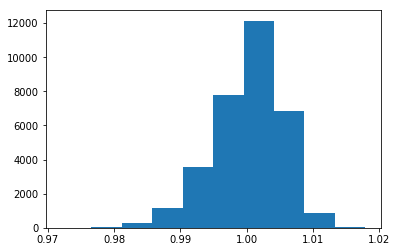

In [14]:
plt.hist((im[0]/im[1]).flatten())


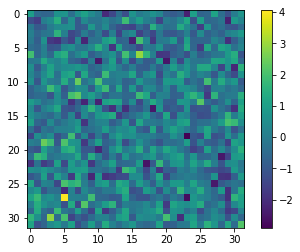

In [61]:
plt.imshow(ix[0][0,...,0,0])
plt.colorbar()

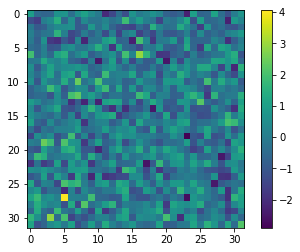

In [65]:
plt.imshow(ixx[0,...,0,0])
plt.colorbar()

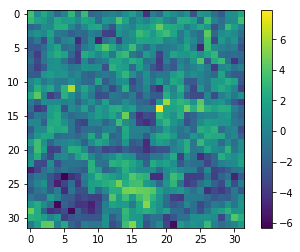

In [66]:
plt.imshow(ixtrue[0,...,0,0])
plt.colorbar()

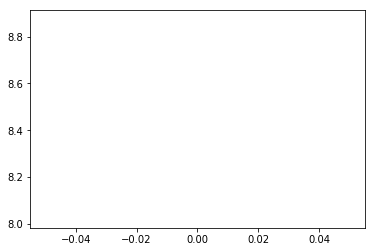

In [780]:
plt.plot(llist)

(array([3.0000e+00, 4.0000e+00, 1.7000e+01, 3.7000e+01, 1.2100e+02,
        3.7000e+02, 1.2100e+03, 4.9760e+03, 2.3129e+04, 2.9010e+03]),
 array([-0.00730299, -0.00642669, -0.0055504 , -0.0046741 , -0.0037978 ,
        -0.00292151, -0.00204521, -0.00116892, -0.00029262,  0.00058367,
         0.00145997], dtype=float32),
 <a list of 10 Patch objects>)

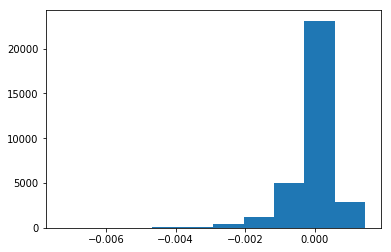

In [781]:
plt.hist(ig[0].flatten())

In [86]:
# plt.hist(ix[0].flatten())
# plt.hist(ix[1].flatten())
# # plt.hist(ix[2].flatten())

In [87]:
# plt.subplot(131)
# plt.imshow(np.squeeze(ix[0]).sum(axis=0))
# plt.subplot(132)
# plt.imshow(np.squeeze(ix[-1]).sum(axis=0))
# plt.subplot(133)
# plt.imshow(np.squeeze(ixtrue).sum(axis=0))

In [182]:
# def graphdmRIM(config, data, sigma=0.01**0.5, maxiter=100, anneal=False, gtol=1e-5):

#     bs, nc = config['boxsize'], config['nc']
#     kmesh = sum(kk**2 for kk in config['kvec'])**0.5
#     priorwt = config['ipklin'](kmesh) * bs ** -3

#     g = tf.Graph()

#     with g.as_default():

#         initlin = tf.placeholder(tf.float32, data.shape, name='initlin')
#         linear = tf.get_variable('linmesh', shape=(nc, nc, nc),
#                              initializer=tf.random_normal_initializer(), trainable=True)
#         initlin_op = linear.assign(initlin, name='initlin_op')
#         #PM                                                                                                                                                                                                                       
#         icstate = tfpm.lptinit(linear, config, name='icstate')
#         fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
#         final = tf.zeros_like(linear)
#         final = tfpf.cic_paint(final, fnstate[0], boxsize=bs, name='final')

#         #   
#               #                                                                                                                                                                                                                         
#         #Prior                                                                                                                                                                                                                    
#         lineark = tfpf.r2c3d(linear, norm=nc**3)
#         priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
#         prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt))
#         prior = tf.multiply(prior, 1/nc**3, name='prior')

#         likelihood = tf.subtract(final, data)
#         likelihood = tf.multiply(likelihood, 1/sigma)
#         ##Anneal                                                                                                                                                                                                                  
#         Rsm = tf.placeholder(tf.float32, name='smoothing')

#         #annealing is smoothing the difference, before squaring, with gaussian smoothing
#         if anneal :
#             print('\nAdding annealing part to graph\n')
#             Rsm = tf.multiply(Rsm, bs/nc)
#             Rsmsq = tf.multiply(Rsm, Rsm)
#             smwts = tf.exp(tf.multiply(-kmesh**2, Rsmsq))
#             likelihood = tf.squeeze(likelihood)
#             likelihoodk = tfpf.r2c3d(likelihood, norm=nc**3)
#             likelihoodk = tf.multiply(likelihoodk, tf.cast(smwts, tf.complex64))
#             residual = tfpf.c2r3d(likelihoodk, norm=nc**3)
#         else:
#             residual = tf.identity(likelihood)

#         chisq = tf.multiply(residual, residual)
#         chisq = tf.reduce_sum(chisq)
#         chisq = tf.multiply(chisq, 1/nc**3, name='chisq')

#         loss = tf.add(chisq, prior, name='loss')
           
#         optimizer = ScipyOptimizerInterface(loss, var_list=[linear], method='L-BFGS-B',
#                                             options={'maxiter': maxiter, 'gtol':gtol})

#         tf.add_to_collection('inits', [initlin_op, initlin])
#         tf.add_to_collection('opt', optimizer)
#         tf.add_to_collection('diagnostics', [prior, chisq, loss])
#         tf.add_to_collection('reconpm', [linear, final, fnstate])
#         tf.add_to_collection('data', data)
#     return g

# Create the simulator and the data

The simulator is defined as $y=Ax + n$ where $A$ is a deterministic matrix and $n \sim \mathcal{N}(0,\sigma^2)$ with $\sigma$ known. The loss will then be defined to be $\mathcal{L}(x,y)=\frac{1}{2} x^T A^T A x - y^T A x$.


In [55]:
nb_samples = 100
batch_size = 16
time_max_rim = 30
time_max_gd = 60
nb_epochs = 2

size_train = 1000
size_test = 500



In [56]:
def simulate(x, A, sigma):
    return np.dot(A,x) + np.random.normal(0,sigma, (2,))

def generate_A():
    D = np.diag(np.random.choice([-1,1], (2,)) * np.random.uniform(0.25, 1, (2,)))
    theta = np.random.uniform(0,2*np.pi)
    P = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return np.linalg.inv(P).dot(D).dot(P)
    

In [57]:
A_train = np.array([generate_A() for i in range(size_train)])
sigma_train = np.array([np.abs(np.random.uniform(0, 1)) for i in range(size_train)])

X_train = np.array([np.random.uniform(-5, 5, (2,)) for i in range(size_train)])
Y_train = np.array([simulate(x, A, sigma) for (x, A, sigma) in zip(X_train, A_train, sigma_train)])
X_min_train = np.array([np.linalg.inv(A).dot(y) for (A,y) in zip(A_train,Y_train)])
X0_train = np.array([x_min + np.random.uniform(-10,10,(2,)) for x_min in X_min_train])

#
A_test = np.array([generate_A() for i in range(size_test)])
sigma_test = np.array([np.abs(np.random.uniform(0, 1)) for i in range(size_test)])

X_test = np.array([np.random.uniform(-5, 5, (2,)) for i in range(size_test)])
Y_test = np.array([simulate(x, A, sigma) for (x, A, sigma) in zip(X_test, A_test, sigma_test)])
X_min_test = np.array([np.linalg.inv(A).dot(y) for (A,y) in zip(A_test,Y_test)])
X0_test = np.array([x_min + np.random.uniform(-10,10,(2,)) for x_min in X_min_test])


In [58]:
def loss(x, y, A):
    return 0.5 * x.T.dot(A.T).dot(A).dot(x) -  y.T.dot(A).dot(x)

def gradient(x, y, A):
    return A.T.dot(A.dot(x) - y)



In [59]:
extent_x, extent_y = 14, 6
xx_grid = np.array([np.linspace(x_min[0]-extent_x, x_min[0]+extent_x, 50) for x_min in X_min_test])
yy_grid = np.array([np.linspace(x_min[1]-extent_y, x_min[1]+extent_y, 50) for x_min in X_min_test])


XY_grid = np.array([np.meshgrid(xx, yy) for (xx,yy) in zip(xx_grid, yy_grid)])
X_grid = XY_grid[:,0,:,:]
Y_grid = XY_grid[:,1,:,:]
grid = np.concatenate([X_grid[:,:,:,np.newaxis], Y_grid[:,:,:,np.newaxis]], axis=3)

Z_grid = np.array([np.apply_along_axis(lambda x: loss(x, y, A), 2, g) for (y,A,g) in zip(Y_test, A_test, grid)])




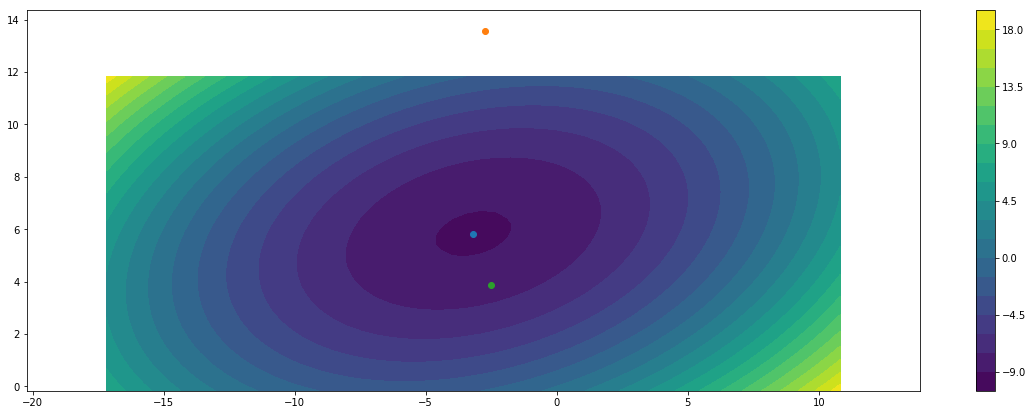

In [60]:

i_example = 37

plt.rcParams['figure.figsize'] = (20,7)
plt.axis('equal')

plt.contourf(X_grid[i_example], Y_grid[i_example], Z_grid[i_example], 20)
plt.colorbar()
plt.scatter(X_min_test[i_example][0], X_min_test[i_example][1])
plt.scatter(X_test[i_example][0], X_test[i_example][1], color=colormap[2])
plt.scatter(X0_test[i_example][0], X0_test[i_example][1])




# Gradient Descent

In [61]:
lr = 0.1
list_xt_gd = []

for (x0, y, A) in zip(X0_test, Y_test, A_test):
# for (x0, y, A) in zip(X0_train, Y_train, A_train):
    xt = x0.copy()
    list_xt = [x0]
    for t in range(1, time_max_gd):
        xt = xt - lr * gradient(xt, y, A)
        list_xt.append(xt)
    list_xt_gd.append(list_xt)
list_xt_gd = np.array(list_xt_gd)

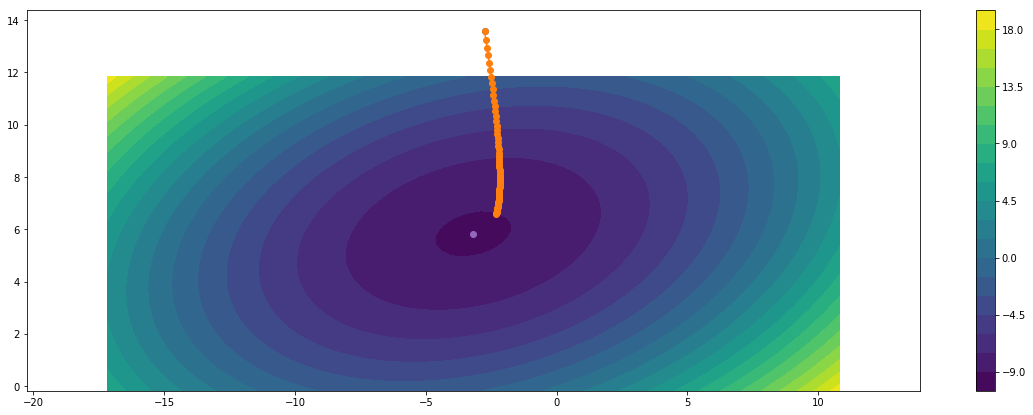

In [62]:
i_example = 37

plt.rcParams['figure.figsize'] = (20,7)
plt.axis('equal')

plt.contourf(X_grid[i_example], Y_grid[i_example], Z_grid[i_example], 20)
plt.colorbar()
plt.scatter(X_min_test[i_example][0], X_min_test[i_example][1], c=colormap[4])
plt.scatter(X0_test[i_example][0], X0_test[i_example][1])
# plt.scatter(X_min_train[i_example][0], X_min_train[i_example][1], c=colormap[4])
# plt.scatter(X0_train[i_example][0], X0_train[i_example][1])

plt.plot(list_xt_gd[i_example,:,0], list_xt_gd[i_example,:,1], color=colormap[1])
plt.scatter(list_xt_gd[i_example,:,0], list_xt_gd[i_example,:,1], c=colormap[1])

# RIM

In [63]:
# https://github.com/kaustubhhiware/LSTM-GRU-from-scratch/blob/80eb6bca2192e40dd718c6c7bd8830119d78a620/module.py
    
class GRU_cell(object):

    def __init__(self, name, input_nodes, hidden_unit, output_nodes):

        self.input_nodes = input_nodes
        self.hidden_unit = hidden_unit
        self.output_nodes = output_nodes
        self.name = name
        
        self.Wx = tf.Variable(tf.zeros([self.input_nodes, self.hidden_unit]), name=name+'/Wx')

        self.Wr = tf.Variable(tf.zeros([self.input_nodes, self.hidden_unit]), name=name+'/Wr')
        self.br = tf.Variable(tf.truncated_normal([self.hidden_unit], mean=1), name=name+'/br')
        
        self.Wz = tf.Variable(tf.zeros([self.input_nodes, self.hidden_unit]), name=name+'/Wz')
        self.bz = tf.Variable(tf.truncated_normal([self.hidden_unit], mean=1), name=name+'/bx')

        self.Wh = tf.Variable(tf.zeros([self.hidden_unit, self.hidden_unit]), name=name+'/Wh')

        self.Wo = tf.Variable(tf.truncated_normal([self.hidden_unit, self.output_nodes], 
                                                  mean=1, stddev=.01), name=name+'/Wo')
        self.bo = tf.Variable(tf.truncated_normal([self.output_nodes], 
                                                  mean=1, stddev=.01), name=name+'/b0')

        self._inputs = tf.placeholder(tf.float32, shape=[None, self.input_nodes])
        self.initial_hidden = tf.zeros_like(self._inputs)
        self.initial_hidden = tf.matmul(self.initial_hidden, tf.zeros([input_nodes, hidden_unit]))

        
    def Gru(self, previous_hidden_state, x):

        z = tf.sigmoid(tf.matmul(x, self.Wz) + self.bz)
        r = tf.sigmoid(tf.matmul(x, self.Wr) + self.br)

        h_ = tf.tanh(tf.matmul(x, self.Wx) +
                     tf.matmul(previous_hidden_state, self.Wh) * r)

        current_hidden_state = tf.multiply( (1 - z), h_) + tf.multiply(previous_hidden_state, z)

        return current_hidden_state

    def get_output(self, hidden_state):
#         output = tf.nn.relu(tf.matmul(hidden_state, self.Wo) + self.bo)
        output = tf.nn.leaky_relu(tf.matmul(hidden_state, self.Wo) + self.bo)
        return output



In [64]:
# tf.reset_default_graph()


# output_size = 2
# hidden_size = 10
# tsteps = 1
# batch_size = None


# xtrue = tf.placeholder(shape=[batch_size, output_size], dtype=tf.float32)
# xinp = tf.placeholder(shape=[batch_size, output_size], dtype=tf.float32)
# AA = tf.placeholder(shape=[batch_size, output_size, output_size], dtype=tf.float32)
# yy = tf.placeholder(shape=[batch_size,  output_size], dtype=tf.float32)

# #
# xx = xinp

# # fidloss =  0.5 * tf.einsum(x.T.dot(A.T).dot(A).dot(x) -  y.T.dot(A).dot(x)
# fidloss =  0.5 * tf.einsum('bi,bi->b', xx, tf.einsum('bij,bi->bj', AA, tf.einsum('bij,bj->bi', AA, xx)                                                       ))
# fidloss = fidloss -  tf.einsum('bi,bi->b', yy, tf.einsum('bij, bj->bi', AA, xx))
# xgrad =  tf.einsum('bij,bi->bj', AA, tf.einsum('bij,bj->bi', AA, xx) - yy)
# ygrad = tf.gradients(fidloss, xx)

# sess = tf.Session()
# sess.run(tf.global_variables_initializer())


# # ind = np.random.choice(np.arange(10), 10, replace=False)
# ind = np.arange(10).astype(int)
# print(ind)
# ix0, ixx, iyy, iAA = X0_train[ind], X_train[ind], Y_train[ind], A_train[ind]

# tmp = sess.run([fidloss, xgrad, ygrad], {xinp:ix0, xtrue:ixx, yy:iyy, AA:iAA})


In [71]:
tf.reset_default_graph()


output_size = 2
hidden_size = 10
tsteps = 1
batch_size = None


xtrue = tf.placeholder(shape=[batch_size, output_size], dtype=tf.float32)
xinp = tf.placeholder(shape=[batch_size, output_size], dtype=tf.float32)
AA = tf.placeholder(shape=[batch_size, output_size, output_size], dtype=tf.float32)
yy = tf.placeholder(shape=[batch_size,  output_size], dtype=tf.float32)


##
losst = tf.get_variable('loss', initializer=0.)
reset_loss = losst.assign(0)

#
mygru = GRU_cell('1', output_size*2, hidden_size, output_size)
# h0 = tf.zeros_like(xinp) 
h0 = mygru.initial_hidden


#
xx = xinp
hidden = h0
xiter = [xx]

# fidloss =  0.5 * tf.einsum(x.T.dot(A.T).dot(A).dot(x) -  y.T.dot(A).dot(x)

for i in range(10):
#     xgrad =  tf.einsum('bij,bi->bj', AA, tf.einsum('bij,bj->bi', AA, xx) - yy)
    xt = tf.stop_gradient(xx)
    fidloss =  0.5 * tf.einsum('bi,bi->b', xt, tf.einsum('bij,bi->bj', AA, tf.einsum('bij,bj->bi', AA, xt))) \
            -  tf.einsum('bi,bi->b', yy, tf.einsum('bij, bj->bi', AA, xt))

    xgrad =  tf.gradients(fidloss, [xt])[0]
    xcat = tf.concat([xx, xgrad], axis=-1)
    hidden = mygru.Gru(hidden, xcat)
    out = mygru.get_output(hidden)
    xout = xx + out
    losst = losst + tf.reduce_sum((xout - xtrue)**2)
    xx = xout
    xiter.append(xx)

opt = tf.train.AdamOptimizer(learning_rate=0.01)
opt_op = opt.minimize(losst)

In [72]:
start = time.time()
#Train

# with tf.Session() as sess:
sess = tf.Session()    
sess.run(tf.global_variables_initializer())

llist = []
for nb in range(1000):
    if nb %100 == 0: print('Step : ', nb)
    ind = np.random.choice(X_train.shape[0], 1024)
    ix0, ixx, iyy, iAA = X0_train[ind], X_train[ind], Y_train[ind], A_train[ind]
#     ind = np.random.choice(X_test.shape[0], 512)
#     ix0, ixx, iyy, iAA = X0_test[ind], X_test[ind], Y_test[ind], A_test[ind]

    _, l, ix = sess.run([opt_op, losst, xiter], 
                                      {xinp:ix0, xtrue:ixx, yy:iyy, AA:iAA,
                                       mygru._inputs:np.concatenate([ix0, ix0], axis=1)})
    llist.append(l)

print(time.time()-start)

Step :  0
Step :  100
Step :  200
Step :  300
Step :  400
Step :  500
Step :  600
Step :  700
Step :  800
Step :  900
26.183045625686646


[]

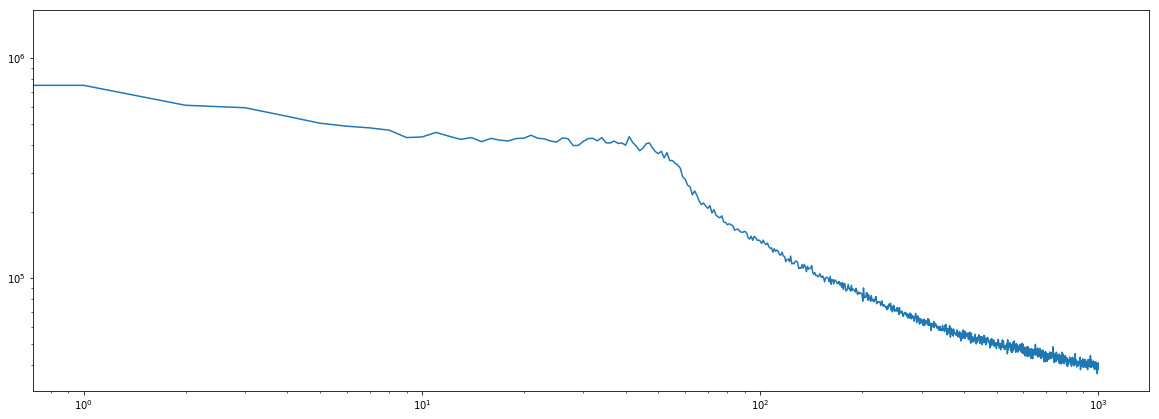

In [73]:
plt.plot(llist)
plt.loglog()

453


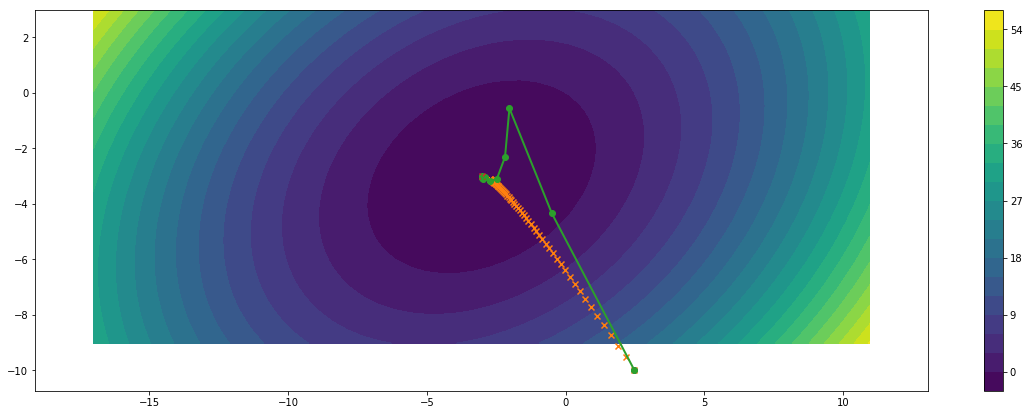

In [81]:
i_example = np.random.choice(X_test.shape[0])
print(i_example)

checklosses = []
checkstates = []

ind = np.array([i_example])
ix0, ixx, iyy, iAA = X0_test[ind], X_test[ind], Y_test[ind], A_test[ind]
# ix0, ixx, iyy, iAA = X0_train[ind], X_train[ind], Y_train[ind], A_train[ind]

il = 0 
checkstates.append(ix0)
_, l, ix = sess.run([opt_op, losst, xiter], 
                                  {xinp:ix0, xtrue:ixx, yy:iyy, AA:iAA,
                                   mygru._inputs:np.concatenate([ix0, ix0], axis=1)})

# checkstates = np.squeeze(np.array(checkstates))
checkstates = np.concatenate(ix)




plt.rcParams['figure.figsize'] = (20,7)
plt.axis('equal')

plt.contourf(X_grid[i_example], Y_grid[i_example], Z_grid[i_example], 20)
plt.colorbar()
plt.scatter(X_min_test[i_example][0], X_min_test[i_example][1], c=colormap[4])
plt.scatter(X0_test[i_example][0], X0_test[i_example][1], marker='o')
# plt.scatter(X_min_train[i_example][0], X_min_train[i_example][1], c=colormap[4])
# plt.scatter(X0_train[i_example][0], X0_train[i_example][1])
plt.scatter(list_xt_gd[i_example,:,0], list_xt_gd[i_example,:,1], c=colormap[1], marker ='x')

plt.plot(checkstates[:,0], checkstates[:,1], c=colormap[2], lw=2)
plt.scatter(checkstates[:,0], checkstates[:,1], c=colormap[2], marker ='o')
plt.scatter(checkstates[:,0][-1], checkstates[:,1][-1], c=colormap[3], marker ='x')

# print(checkstates)